In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import xarray.plot as xplot

In [3]:
import ipywidgets as widgets

In [4]:
import xinteractive.interactions as interactive

In [5]:
ds = xr.tutorial.open_dataset('air_temperature')
da = ds['air']
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Interactive indexing via functions and decorators

Select indices via a function

(array([ 965., 2913., 2826., 2309., 2264., 3369., 4619., 4471., 6986.,
        2403.]),
 array([229.59999, 237.09   , 244.57999, 252.06999, 259.56   , 267.05   ,
        274.54   , 282.03   , 289.52   , 297.01   , 304.5    ],
       dtype=float32),
 <a list of 10 Patch objects>)

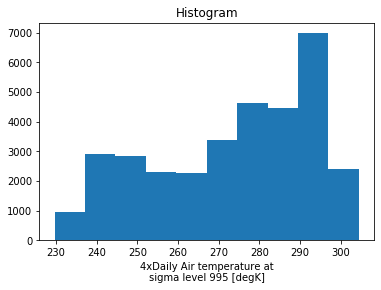

In [6]:
da.isel(time=slice(25, 50)).plot()

In [7]:
interactive.isel(da, xplot.plot, time=slice(25, 50, 1))

interactive(children=(IntRangeSlider(value=(25, 50), continuous_update=False, description='time:', max=2919), …

Or use as a decorator

In [8]:
@interactive.isel(time=20)
def plotter(da):
    return da.plot()  # write as a def?

TypeError: isel() missing 2 required positional arguments: 'da' and 'func'

Select via coords

In [ ]:
@interactive.sel(time='2013-10-03')
lambda: da, da.plot()

Selecting on multiple dimensions produces multiple sliders

In [ ]:
@interactive.sel(lon=30, lat=50)
lambda: da, da.plot()

Interactive decorators can be chained

In [ ]:
@interactive.isel(time=0)
@interactive.sel(lon=30, lat=50)
lambda: da, da.plot()

Slice indexers become range sliders

In [ ]:
@interactive.isel(time=slice(5, 10))
lambda: da, da.mean(dim='time').plot()

and you can pass in custom widgets

In [ ]:
dropdown_date = widgets.Dropdown(options=list(da.coords['time'].values), description='Date:')
interactive.isel(da, xplot.plot, time=dropdown_date)

If you pass in the `Play` widget the function will animate along that index, and show it's progress by creating a corresponding slider

In [ ]:
from ipywidgets import Play
interactive.isel(da, xplot.plot, time=Play())

## Interactivity via `.interactive` accessor methods

The interactivity functions are aslo reachable through a new accessor

In [ ]:
da.interactive.sel(plot, lat=20, lon=60)

## Ideas for interactive method chaining

Ideally though the API would allow for method chaining, i.e.

In [ ]:
location = da.interactive.sel(lat=20, lon=60).plot()  # the dream

This is more challenging though.

Method chaining could be done through an `InteractiveDataArray` subclass, which stores widget information, and decorates plotting methods so that they call `IPython.display`.

In [ ]:
location

In [ ]:
location.widgets

In order to capture the return value of `DataArray` methods without dropping the widgets we would need to decorate all the inherited value-returning methods of `DataArray` with some kind of `@propagate_widgets` decorator.

That would still only allow for a syntax like this though:

In [ ]:
location = da.interactive.sel(lat=20, lon=60).plot()  # change this slider

In [ ]:
location.plot()  # before rerunning this cell

If we want the output of the current cell to change when the interactive accessor method is followed by other chained methods, that's really difficult.

The problem is described [here](): running Python code blocks any widget messages from the frontend until the Python code is done. The whole cell is executed before the javascript widget gets a chance to return anything, so the updated return value of the interactive function, as needed by the chained method, isn't available until the next cell.

```python
w = interactive(func, **kwargs)
w.result
```

There are two possible solutions described [here](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Asynchronous.html) though, but the [first](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Asynchronous.html#Event-loop-integration) uses `asyncio` and the [second](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Asynchronous.html#Generator-approach) uses generators in a kind of hacky way.

I think to use the first approach for interactive plotting would require an initial plot call followed by an update call which uses the `set_data()` method on the axes object. 

## Interactive variable selection

You can choose a particular variable from a dataset interactively

In [ ]:
da = ds.interactive.vars(var='n')

In [ ]:
da.plot()

You can select multiple variables, and feed them into a function by applying as a decorator

In [ ]:
@interactive.vars(ds=ds, var=['n', 'phi'])
def cov(da1, da2): 
    da1.cov(da2).plot()

## Shorthand for exploring every dimension

In [ ]:
interactive.explore(ds, plot)

## Interactively choose dimensions along which to apply function

In [ ]:
@interactive.dims(dim='time')
lambda da: da.mean(dim)